In [161]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

df = pd.read_csv('A3/train.csv', index_col='ArticleId')
X_train = df['Text']
df['Category'].replace(['tech', 'entertainment'], [0,1], inplace=True)
Y_train = df['Category']

df_test = pd.read_csv('A3/test.csv', index_col='ArticleId')
X_test = df_test['Text']
df_test['Category'].replace(['tech', 'entertainment'], [0,1], inplace=True)
Y_test = df_test['Category']

temp_complete_test = pd.concat([X_train, X_test])


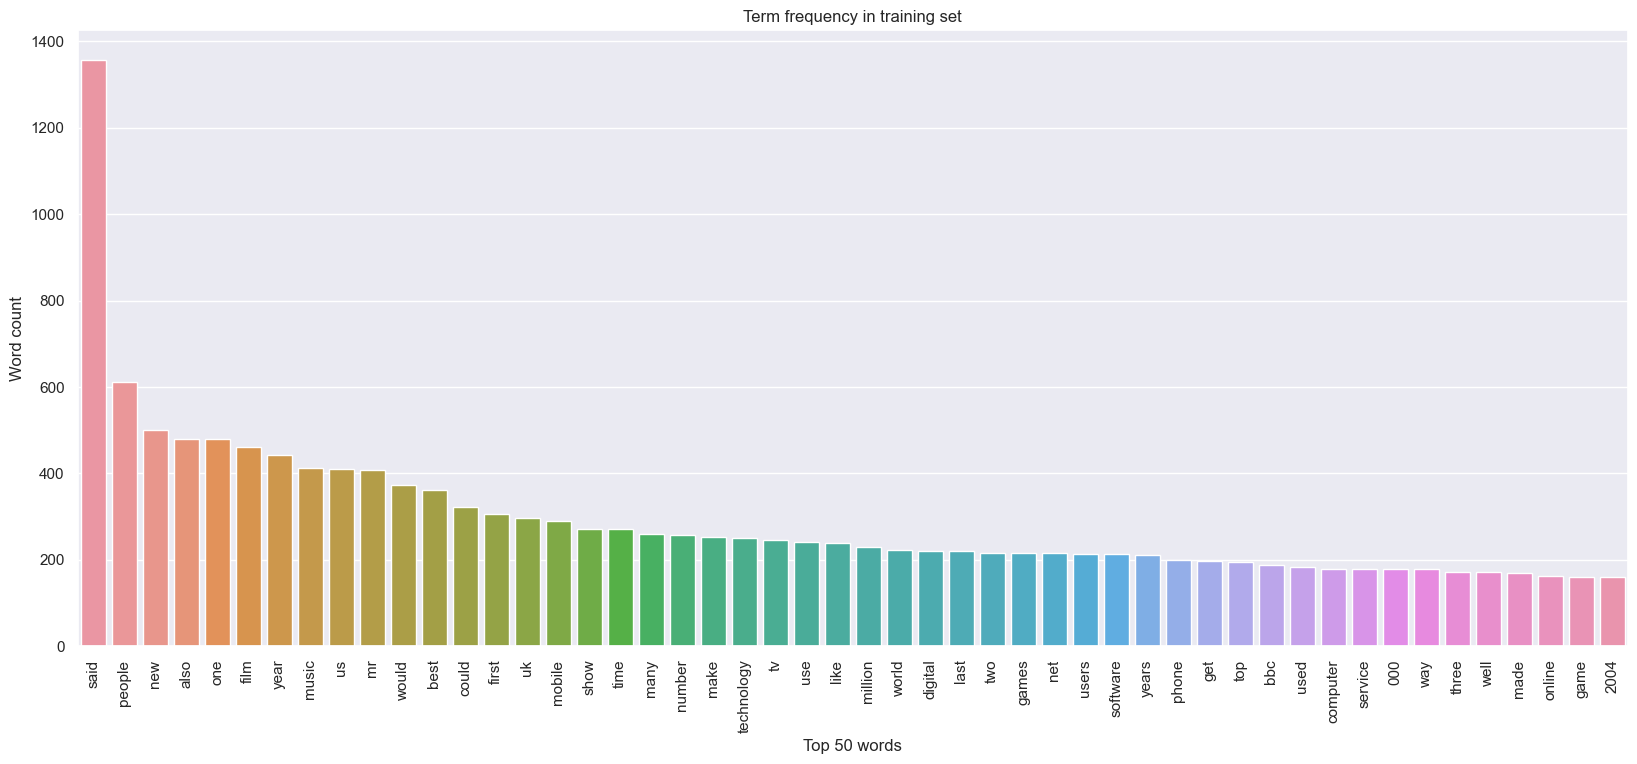

In [75]:
# Frequency count for dataset
vectorizer = CountVectorizer()
vectorizer.fit(temp_complete_test)
# Encode document
vector = vectorizer.transform(temp_complete_test)
prep_X_count = pd.DataFrame(vector.toarray(), columns=sorted(vectorizer.vocabulary_), index=temp_complete_test.index)
#print(prep_X_count)

prep_X_train_count = prep_X_count[:428]
prep_X_test_count = prep_X_count[428:]

train_sum = prep_X_train_count.sum().sort_values(ascending=False)
test_sum = prep_X_test_count.sum().sort_values(ascending=False)

train_top_50 = train_sum.head(50)
sns.set_style('whitegrid')
sns.set(rc = {'figure.figsize':(20,8)})
plot = sns.barplot(x=train_top_50.index, y=train_top_50.values)
plot.set_xlabel('Top 50 words')
plot.set_ylabel('Word count')
plot.set_title('Term frequency in training set')
plt.xticks(rotation = 90)
plt.show()

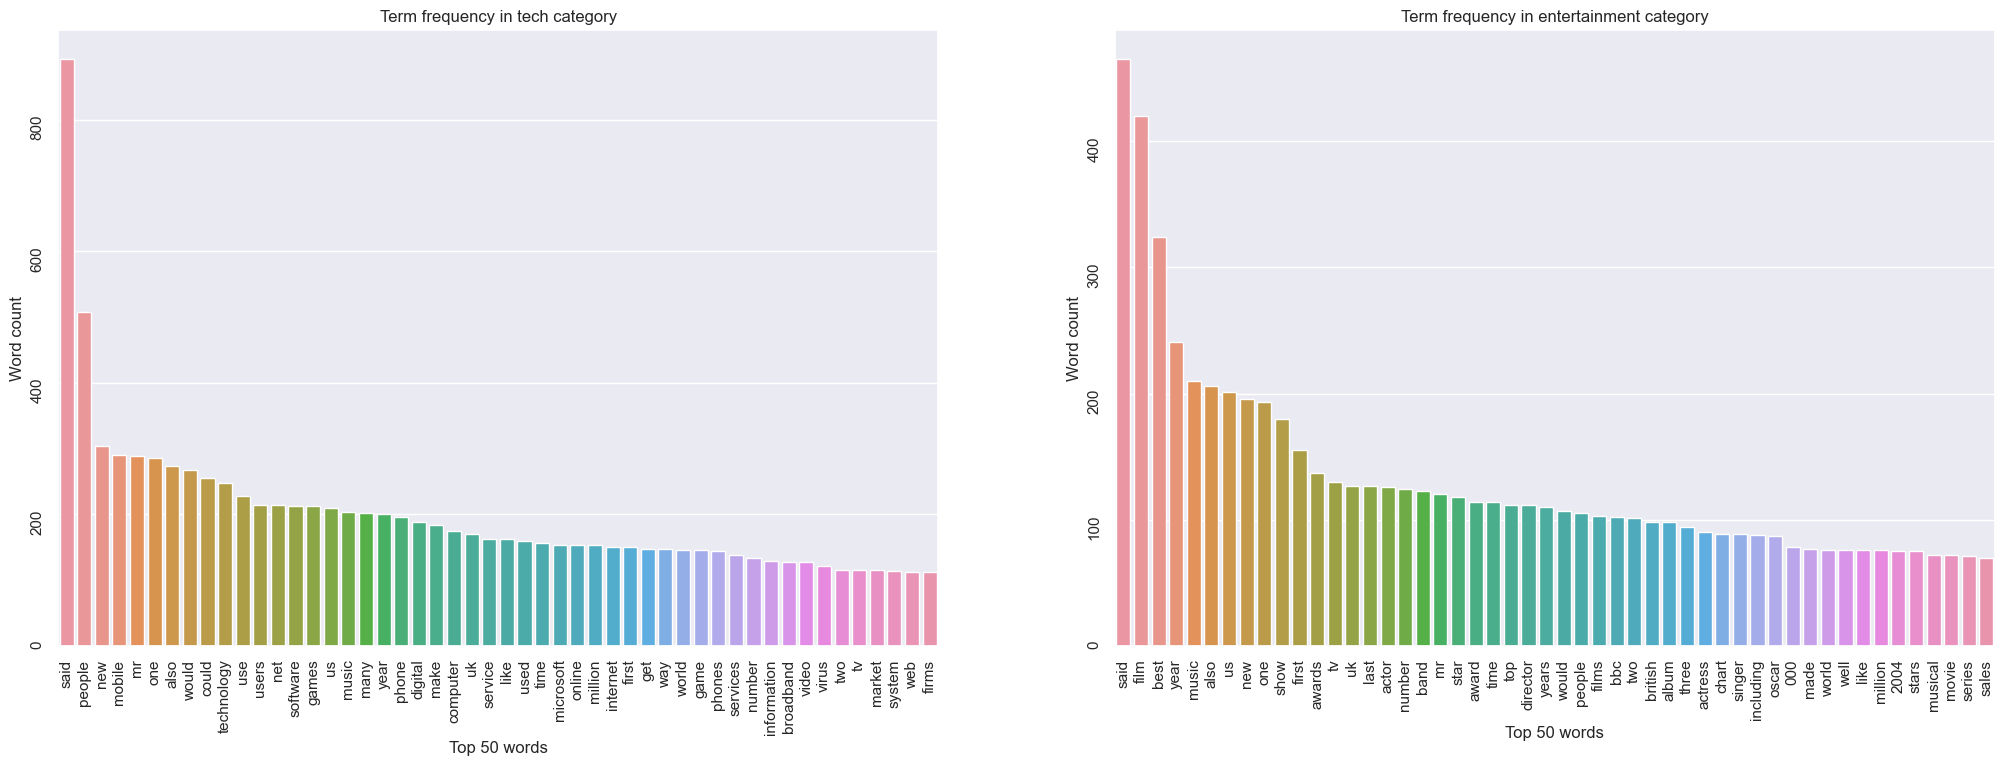

In [76]:
train_label_group = Y_train.groupby(Y_train)
train_tech, train_entertain = train_label_group.get_group(0).index, train_label_group.get_group(1).index

train_tech_sum = prep_X_count.loc[train_tech].sum().sort_values(ascending=False)
train_entertain_sum = prep_X_count.loc[train_entertain].sum().sort_values(ascending=False)

train_top_50_tech = train_tech_sum.head(50)
train_top_50_entertain = train_entertain_sum.head(50)

fig, ax = plt.subplots(ncols=2, figsize=(25, 8))
ax[0] = sns.barplot(x=train_top_50_tech.index, y=train_top_50_tech.values, ax=ax[0])
ax[0].set_xlabel('Top 50 words')
ax[0].set_ylabel('Word count')
ax[0].set_title('Term frequency in tech category')
ax[0].tick_params(labelrotation=90)

ax[1] = sns.barplot(x=train_top_50_entertain.index, y=train_top_50_entertain.values, ax=ax[1])
ax[1].set_xlabel('Top 50 words')
ax[1].set_ylabel('Word count')
ax[1].set_title('Term frequency in entertainment category')
ax[1].tick_params(labelrotation=90)
plt.show()

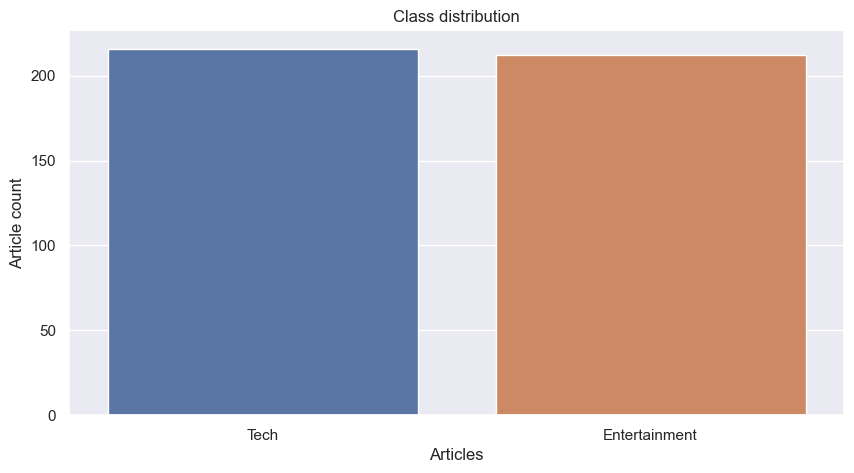

In [77]:
sns.set(rc = {'figure.figsize':(10,5)})
plot = sns.barplot(x=['Tech', 'Entertainment'], y=[train_tech.size, train_entertain.size])
plot.set_xlabel('Articles')
plot.set_ylabel('Article count')
plot.set_title('Class distribution')
plt.show()

In [78]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train)
# summarize
# print(f'vector vocabulary - {vectorizer.vocabulary_}\n')

# encode document
vector = vectorizer.transform(X_test)
prep_X_test = pd.DataFrame(vector.toarray(), columns=sorted(vectorizer.vocabulary_), index=X_test.index)

vector = vectorizer.transform(X_train)
prep_X_train = pd.DataFrame(vector.toarray(), columns=sorted(vectorizer.vocabulary_), index=X_train.index)
print(prep_X_test.shape)
print(prep_X_train.shape)

(106, 13518)
(428, 13518)


# Neural Network

In [79]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import log_loss
import warnings

#warnings.filterwarnings('ignore')

#np.random.seed(1)

init_weigths = np.random.uniform(0., 0.1, 13518)
hid_units = [5,20,40]
results = []

for hid_unit in hid_units:
    clf = MLPClassifier(hidden_layer_sizes=(hid_unit,), solver='sgd', learning_rate_init=0.01, max_iter=100)
    clf.coefs_ = init_weigths

    clf.fit(prep_X_train,Y_train)

    preds = clf.predict(prep_X_test)
    score = clf.score(prep_X_test, Y_test)

    loss = log_loss(Y_test, preds)
    results.append([hid_unit, loss, score])

print(results)

[[5, 0.3400344659350677, 0.9905660377358491], [20, 0.6800689318701351, 0.9811320754716981], [40, 0.3400344659350677, 0.9905660377358491]]


[]

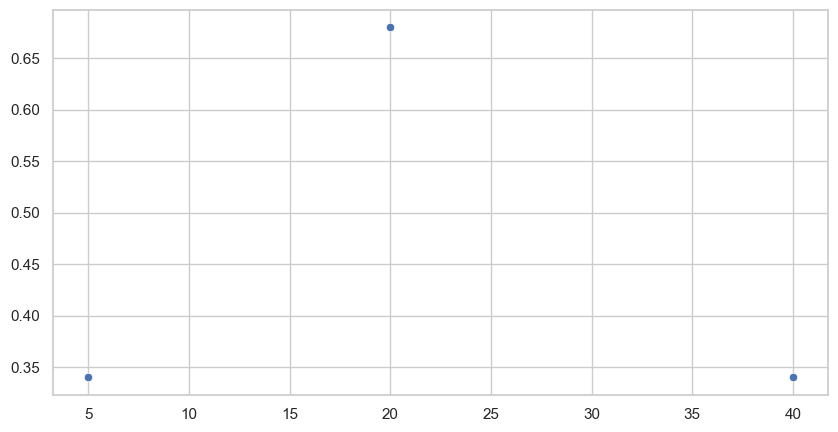

In [80]:
sns.set_style('whitegrid')
results = np.array(results).T
plot = sns.scatterplot(x=results[0], y=results[1])
plt.plot()

# SVM

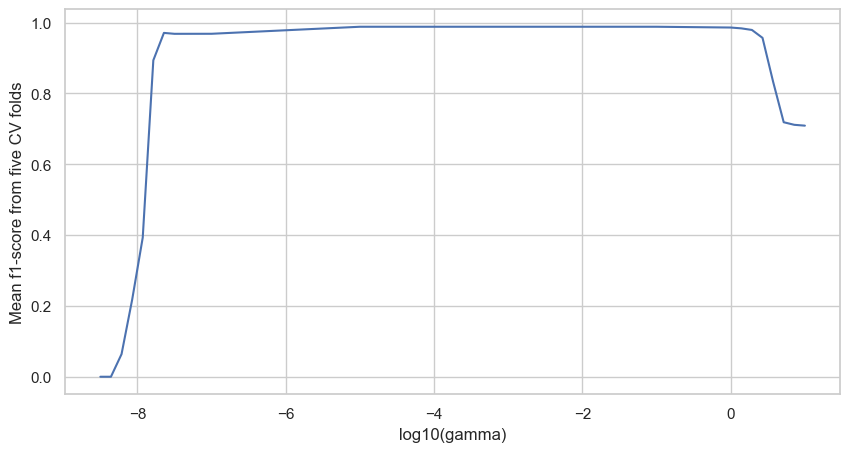

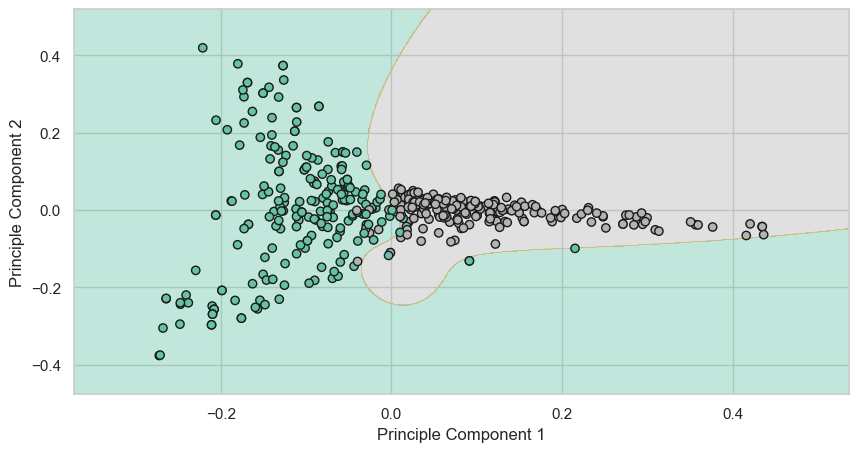

In [228]:
from sklearn import svm


np.random.seed(10)

hyp_arr = np.empty(shape=(20,2))

grange1 = np.logspace(-8.5, -7.5, num = 8)
grange2 = np.logspace(-7, -1, num = 4)
grange3 = np.logspace(0, 1, num = 8)

count = 0

for g in grange1:
    clf = svm.SVC(kernel='rbf', C=10000000, gamma=g)
    cvscores = cross_val_score(clf, prep_X_train, Y_train, cv=5, scoring="f1")
    hyp_arr[count] = (cvscores.mean(), np.log10(g))
    count += 1
    
for g in grange2:
    clf = svm.SVC(kernel='rbf', C=10000000, gamma=g)
    cvscores = cross_val_score(clf, prep_X_train, Y_train, cv=5, scoring="f1")
    hyp_arr[count] = (cvscores.mean(), np.log10(g))
    count += 1

for g in grange3:
    clf = svm.SVC(kernel='rbf', C=10000000, gamma=g)
    cvscores = cross_val_score(clf, prep_X_train, Y_train, cv=5, scoring="f1")
    hyp_arr[count] = (cvscores.mean(), np.log10(g))
    count += 1
    
    
hyp_df = pd.DataFrame(hyp_arr, columns=["Mean f1-score from five CV folds", "log10(gamma)"])
sns.lineplot(hyp_df, x="log10(gamma)", y="Mean f1-score from five CV folds")


# Using non-PCA data.
rbf_svc = svm.SVC(kernel='rbf', C=10000000, gamma=2)
rbf_svc.fit(prep_X_train,Y_train)

preds = rbf_svc.predict(prep_X_test)
score = rbf_svc.score(prep_X_test, Y_test)




# Using PCA data to train and plot decision boundaries.
pca_transformer = PCA(n_components=2)
pca_transformer.fit(prep_X_train)
vector = pca_transformer.transform(prep_X_train)
pca_X_train = pd.DataFrame(vector, index=prep_X_train.index, columns=["x1", "x2"])

vector = pca_transformer.transform(prep_X_test)
pca_X_test = pd.DataFrame(vector, index=prep_X_test.index, columns=["x1", "x2"])

rbf_svc.fit(pca_X_train,Y_train)

preds = rbf_svc.predict(pca_X_test)
score = rbf_svc.score(pca_X_test, Y_test)



# Print PCA decision boundaries.

disp = DecisionBoundaryDisplay.from_estimator(rbf_svc, pca_X_train, response_method="predict", 
                                              alpha=0.4, cmap="Set2", grid_resolution=1000, eps=0.1,
                                              xlabel="Principle Component 1", ylabel="Principle Component 2")
disp.ax_.scatter(pca_X_train["x1"], pca_X_train["x2"], c=Y_train, edgecolor="k", cmap="Set2")
plt.show()




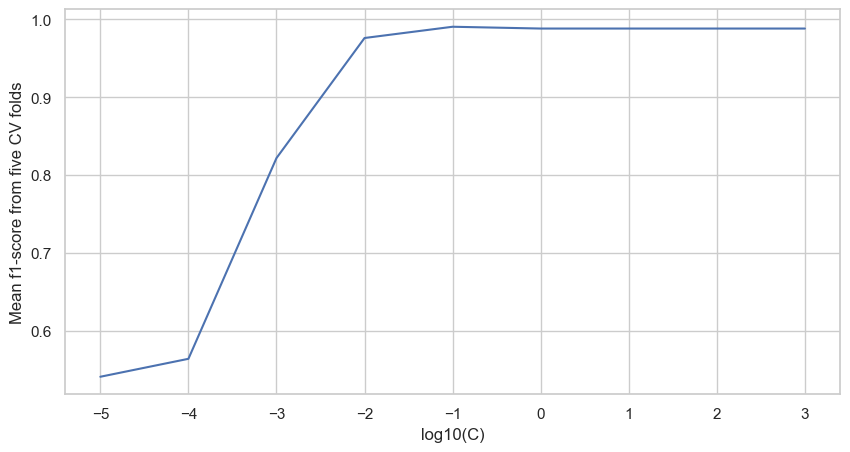

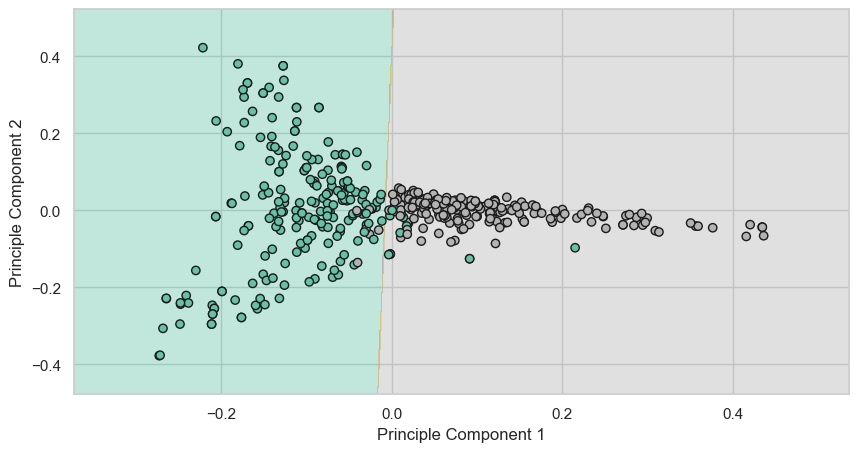

In [229]:
hyp_log = []
scores = []

hyp_arr = np.empty(shape=(9,2))
crange = np.logspace(-5, 3, num = 9)

count = 0

for c in crange:
    clf = svm.LinearSVC(C=c)
    cvscores = cross_val_score(clf, prep_X_train, Y_train, cv=5, scoring="f1")
    hyp_arr[count] = (cvscores.mean(), np.log10(c))
    count += 1


hyp_df = pd.DataFrame(hyp_arr, columns=["Mean f1-score from five CV folds", "log10(C)"])   
sns.lineplot(hyp_df, x="log10(C)", y="Mean f1-score from five CV folds")



# Using non-PCA data.
lin_svc = svm.LinearSVC(C=0.7)
lin_svc.fit(prep_X_train,Y_train)

preds = lin_svc.predict(prep_X_test)
score = lin_svc.score(prep_X_test, Y_test)




# Using PCA data to train and plot decision boundaries.
pca_transformer = PCA(n_components=2)
pca_transformer.fit(prep_X_train)
vector = pca_transformer.transform(prep_X_train)
pca_X_train = pd.DataFrame(vector, index=prep_X_train.index, columns=["x1", "x2"])

vector = pca_transformer.transform(prep_X_test)
pca_X_test = pd.DataFrame(vector, index=prep_X_test.index, columns=["x1", "x2"])

lin_svc.fit(pca_X_train,Y_train)

preds = lin_svc.predict(pca_X_test)
score = lin_svc.score(pca_X_test, Y_test)



# Print PCA decision boundaries.
disp = DecisionBoundaryDisplay.from_estimator(lin_svc, pca_X_train, response_method="predict", 
                                              alpha=0.4, cmap="Set2", grid_resolution=1000, eps=0.1,
                                              xlabel="Principle Component 1", ylabel="Principle Component 2")
disp.ax_.scatter(pca_X_train["x1"], pca_X_train["x2"], c=Y_train, edgecolor="k", cmap="Set2")
plt.show()


Now we find the best Hyperparameter/kernel for the SVM. We consider 

In [ ]:
# Using non-PCA data.
lin_svc = svm.LinearSVC(C=0.7)
lin_svc.fit(prep_X_train,Y_train)

preds = lin_svc.predict(prep_X_test)
score = lin_svc.score(prep_X_test, Y_test)